緣起與目的: 房價高低與房子大小、所在位置、內部裝設...等內容有所關係，如何找出評估或預測房價價格，對許多業主、民眾極其重要，為此如何建立一房價預測模型。在本案例中，將房價設為依變數，而房子大小、所在位置、內部裝設...等設為自變數，利用Gradient boost regression tree方法建立其預測模型。


首先，本案例先將會使用到的套件(package)進行載入，以便後面模型建立做使用

In [29]:
# import
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from math import ceil
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

針對問題，將資料進行載入，針對變數進行以下步驟:

先觀察變數的屬性，通常分為離散及連續。

離散變數：

 a. 其數值只能用自然數或整數單位計算
 b. 或稱為計量單位數，因為都是由計數方法取得。
 c. 例如：企業個數、職工人數、設備台數等。
連續變數：

 a. 在一定區間內可以任意取值。
 b. 其數值是連續不斷的,相鄰兩個數值可作無限分割。
 c. 例如：生產零件的規格尺寸、人體測量的身高、體重、胸圍等。
從資料筆數來看，共有14個離散變數與20個連續變數

利用pd.read_csv 將資料呼叫近來

In [30]:
# load data
# 14 discrete
discrete = ["YearBuilt", "YearRemodAdd", "BsmtFullBath", "BsmtHalfBath", 
            "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr",
            "TotRmsAbvGrd", "Fireplaces", "GarageYrBlt", "GarageCars", 
            "MoSold", "YrSold"]
# 20 continuous
continuous = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", 
              "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", 
              "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", 
              "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", 
              "ScreenPorch", "PoolArea", "MiscVal", "SalePrice"]

df_train = pd.read_csv("C:/Users/HP/Downloads/house/train.csv", index_col="Id")
df_test = pd.read_csv("C:/Users/HP/Downloads/house/test.csv", index_col="Id")
df_train.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
999,30,RM,60.0,9786,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2006,WD,Normal,91000
206,20,RL,99.0,11851,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,180500
504,20,RL,100.0,15602,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,3,2010,WD,Normal,289000
124,120,RL,55.0,7892,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,153900
851,120,RM,36.0,4435,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2007,WD,Normal,131500


變數載入後，優先觀察變數內是否有遺失值，且計算單一變數內有多少遺失值數量

從結果發現，GarageYrBlt(159)、LotFrontage(486)及MasVnrArea(23)為遺失值最多的前三名，其餘皆小於十筆。

程式碼部分，由於欄位有點多，為了省時省力，本案例利用for 迴圈進行遺失值之數量計算。

In [31]:
missing = []
cols = discrete + continuous
cols.remove("SalePrice")
for col in cols:
    cnt = df_train[col].isnull().sum() + df_test[col].isnull().sum()
    if cnt:
        missing.append(col)
        print("%s: %d" % (col, cnt))

BsmtFullBath: 2
BsmtHalfBath: 2
GarageYrBlt: 159
GarageCars: 1
LotFrontage: 486
MasVnrArea: 23
BsmtFinSF1: 1
BsmtFinSF2: 1
BsmtUnfSF: 1
TotalBsmtSF: 1
GarageArea: 1


了解遺失值數量，接著觀察是否有離群值

在方法執行上，本案例利用房價與其他自變數進行比對，觀察是否有房價因變數中有離群值，而產生巨大差異

在離群值上，本案例假設

LotArea: 150000
BsmtFinSF1: 4000
TotalBsmtSF: 6000
1stFlrSF: 4000
GrLivArea: 5000

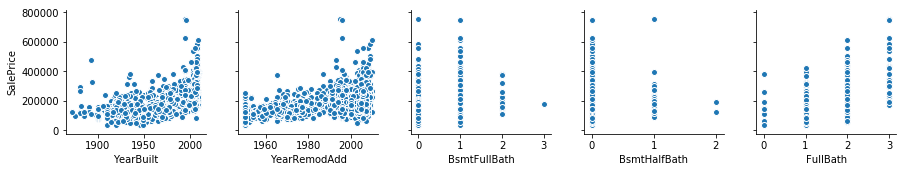

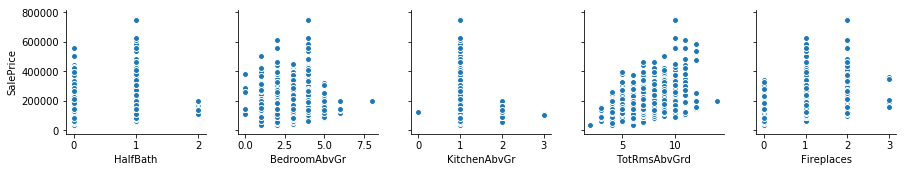

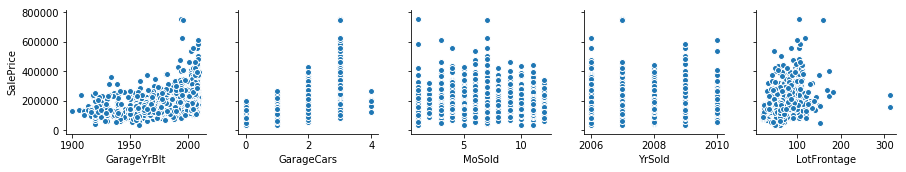

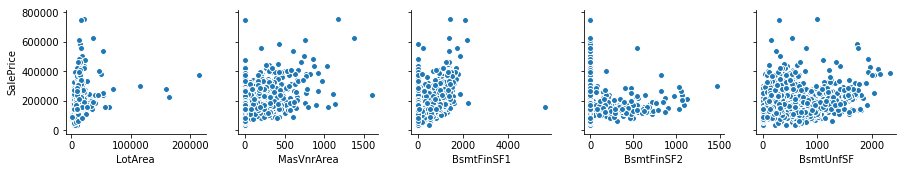

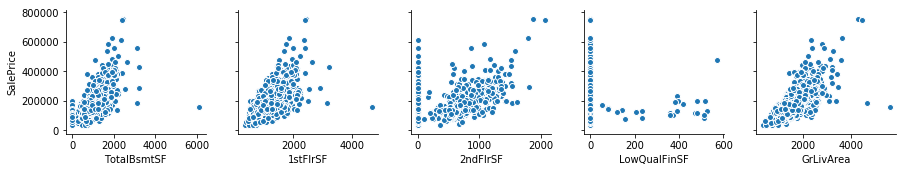

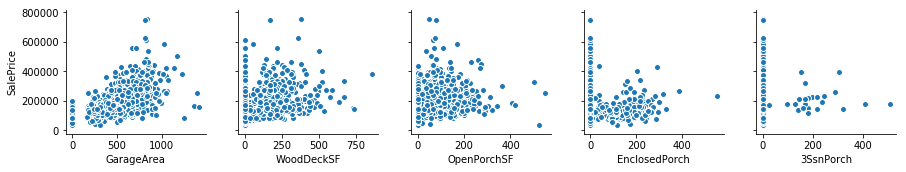

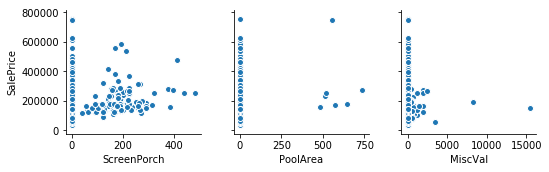

In [32]:
# chunks
def chunks(l, n):
    return [l[i:i + n] for i in range(0, len(l), n)]
cols = discrete + continuous
cols.remove('SalePrice')
data = pd.concat([df_train['SalePrice'], df_train[cols]], axis=1)
for lst in chunks(cols, 5):
    sns.pairplot(data, y_vars=['SalePrice'], x_vars=lst)

outliers = {"LotArea": 150000, "BsmtFinSF1": 4000, "TotalBsmtSF": 6000, 
            "1stFlrSF": 4000, "GrLivArea": 5000}

利用房價變數，觀察此變數是哪一種分布，在本案例中，先以常態(norm)作為fit。 從結果來看，此變數不為常態分布

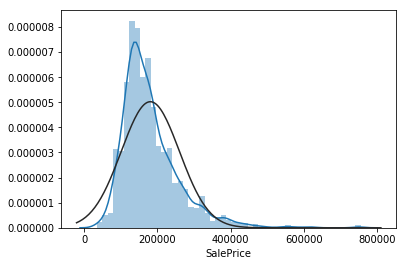

In [33]:
sns.distplot(df_train['SalePrice'], fit=norm);

當瞭解以上資訊後，首先須找出有遺失值的數據。 在此定義impute 找出每一變數之遺失值

In [34]:
# impute missing values
def impute(df, cols):
    for col in cols:
        df[col] = df[col].fillna(df[col].mean())

impute(df_train, missing)
impute(df_test, missing)
df_train.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
548,85,RL,54.000000,7244,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2007,WD,Normal,129500
810,75,RM,90.000000,8100,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,106000
487,20,RL,79.000000,10289,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,156000
1272,20,RL,70.049958,9156,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,185750
676,160,RL,24.000000,2289,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,148500


當找出所有遺失值後，接著去除離群值，在本案例中，已先前設定 LotArea: 150000 BsmtFinSF1: 4000 TotalBsmtSF: 6000 1stFlrSF: 4000 GrLivArea: 5000

執行結果為原本為1460筆，刪除後為1456筆

In [35]:
# clean outliers
def clean_outliers(df, outliers):
    for col in outliers:
        df = df[df[col] < outliers[col]]
    return df

print("Before cleaning: %d" % len(df_train))
df_train = clean_outliers(df_train, outliers)
print("After cleaning: %d" % len(df_train))

Before cleaning: 1460
After cleaning: 1456


將類別變數，利用數值進行編號，

類別變數如下: "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical", "KitchenQual", "Functional", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", "MiscFeature", "SaleType", "SaleCondition"

編號如下: "NONE": 0, "Po": 1, "Fa": 2, "TA": 4, "Gd": 7, "Ex": 11

In [36]:
categorical = ["MSZoning", "Street", "Alley", "LotShape", "LandContour", 
               "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1",
               "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl",
               "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond",
               "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
               "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical",
               "KitchenQual", "Functional", "FireplaceQu", "GarageType", "GarageFinish",
               "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", "MiscFeature",
               "SaleType", "SaleCondition"]
icategorical = ["MSSubClass", "OverallQual", "OverallCond"]

qual_dict = {"NONE": 0, "Po": 1, "Fa": 2, "TA": 4, "Gd": 7, "Ex": 11}
qual_cols = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", 
             "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]

def discretize(df, cols):
    for col in cols:
        df[col] = df[col].fillna("NONE")
        if col in qual_cols:
            df[col] = df[col].map(qual_dict).astype('int')
        else:
            df[col] = df[col].astype('category')
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

dataset = pd.concat(objs=[df_train, df_test], axis=0)
discretize(dataset, categorical)
idx = len(df_train)
df_train = dataset[:idx]
df_test = dataset[idx:]
df_train.sample(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1248,1034,0,0,1,3,0,4,0,539.0,0.0,...,9,0,1,6,1012.0,0,0,1976,1976,2010
636,1440,1440,0,2,8,1,2,4,256.0,0.0,...,9,0,1,14,1440.0,0,0,1914,1995,2007
981,999,0,0,1,3,0,4,0,867.0,0.0,...,9,0,1,6,944.0,0,144,1961,2007,2008
630,1350,0,0,1,3,0,4,1,624.0,336.0,...,9,0,1,6,1248.0,0,176,1964,1964,2008
979,894,0,0,1,3,0,4,4,552.0,0.0,...,9,0,1,5,894.0,0,0,1954,1954,2007


了解數值變數(包含離散與連續)的偏態狀態，所有變數皆為左偏

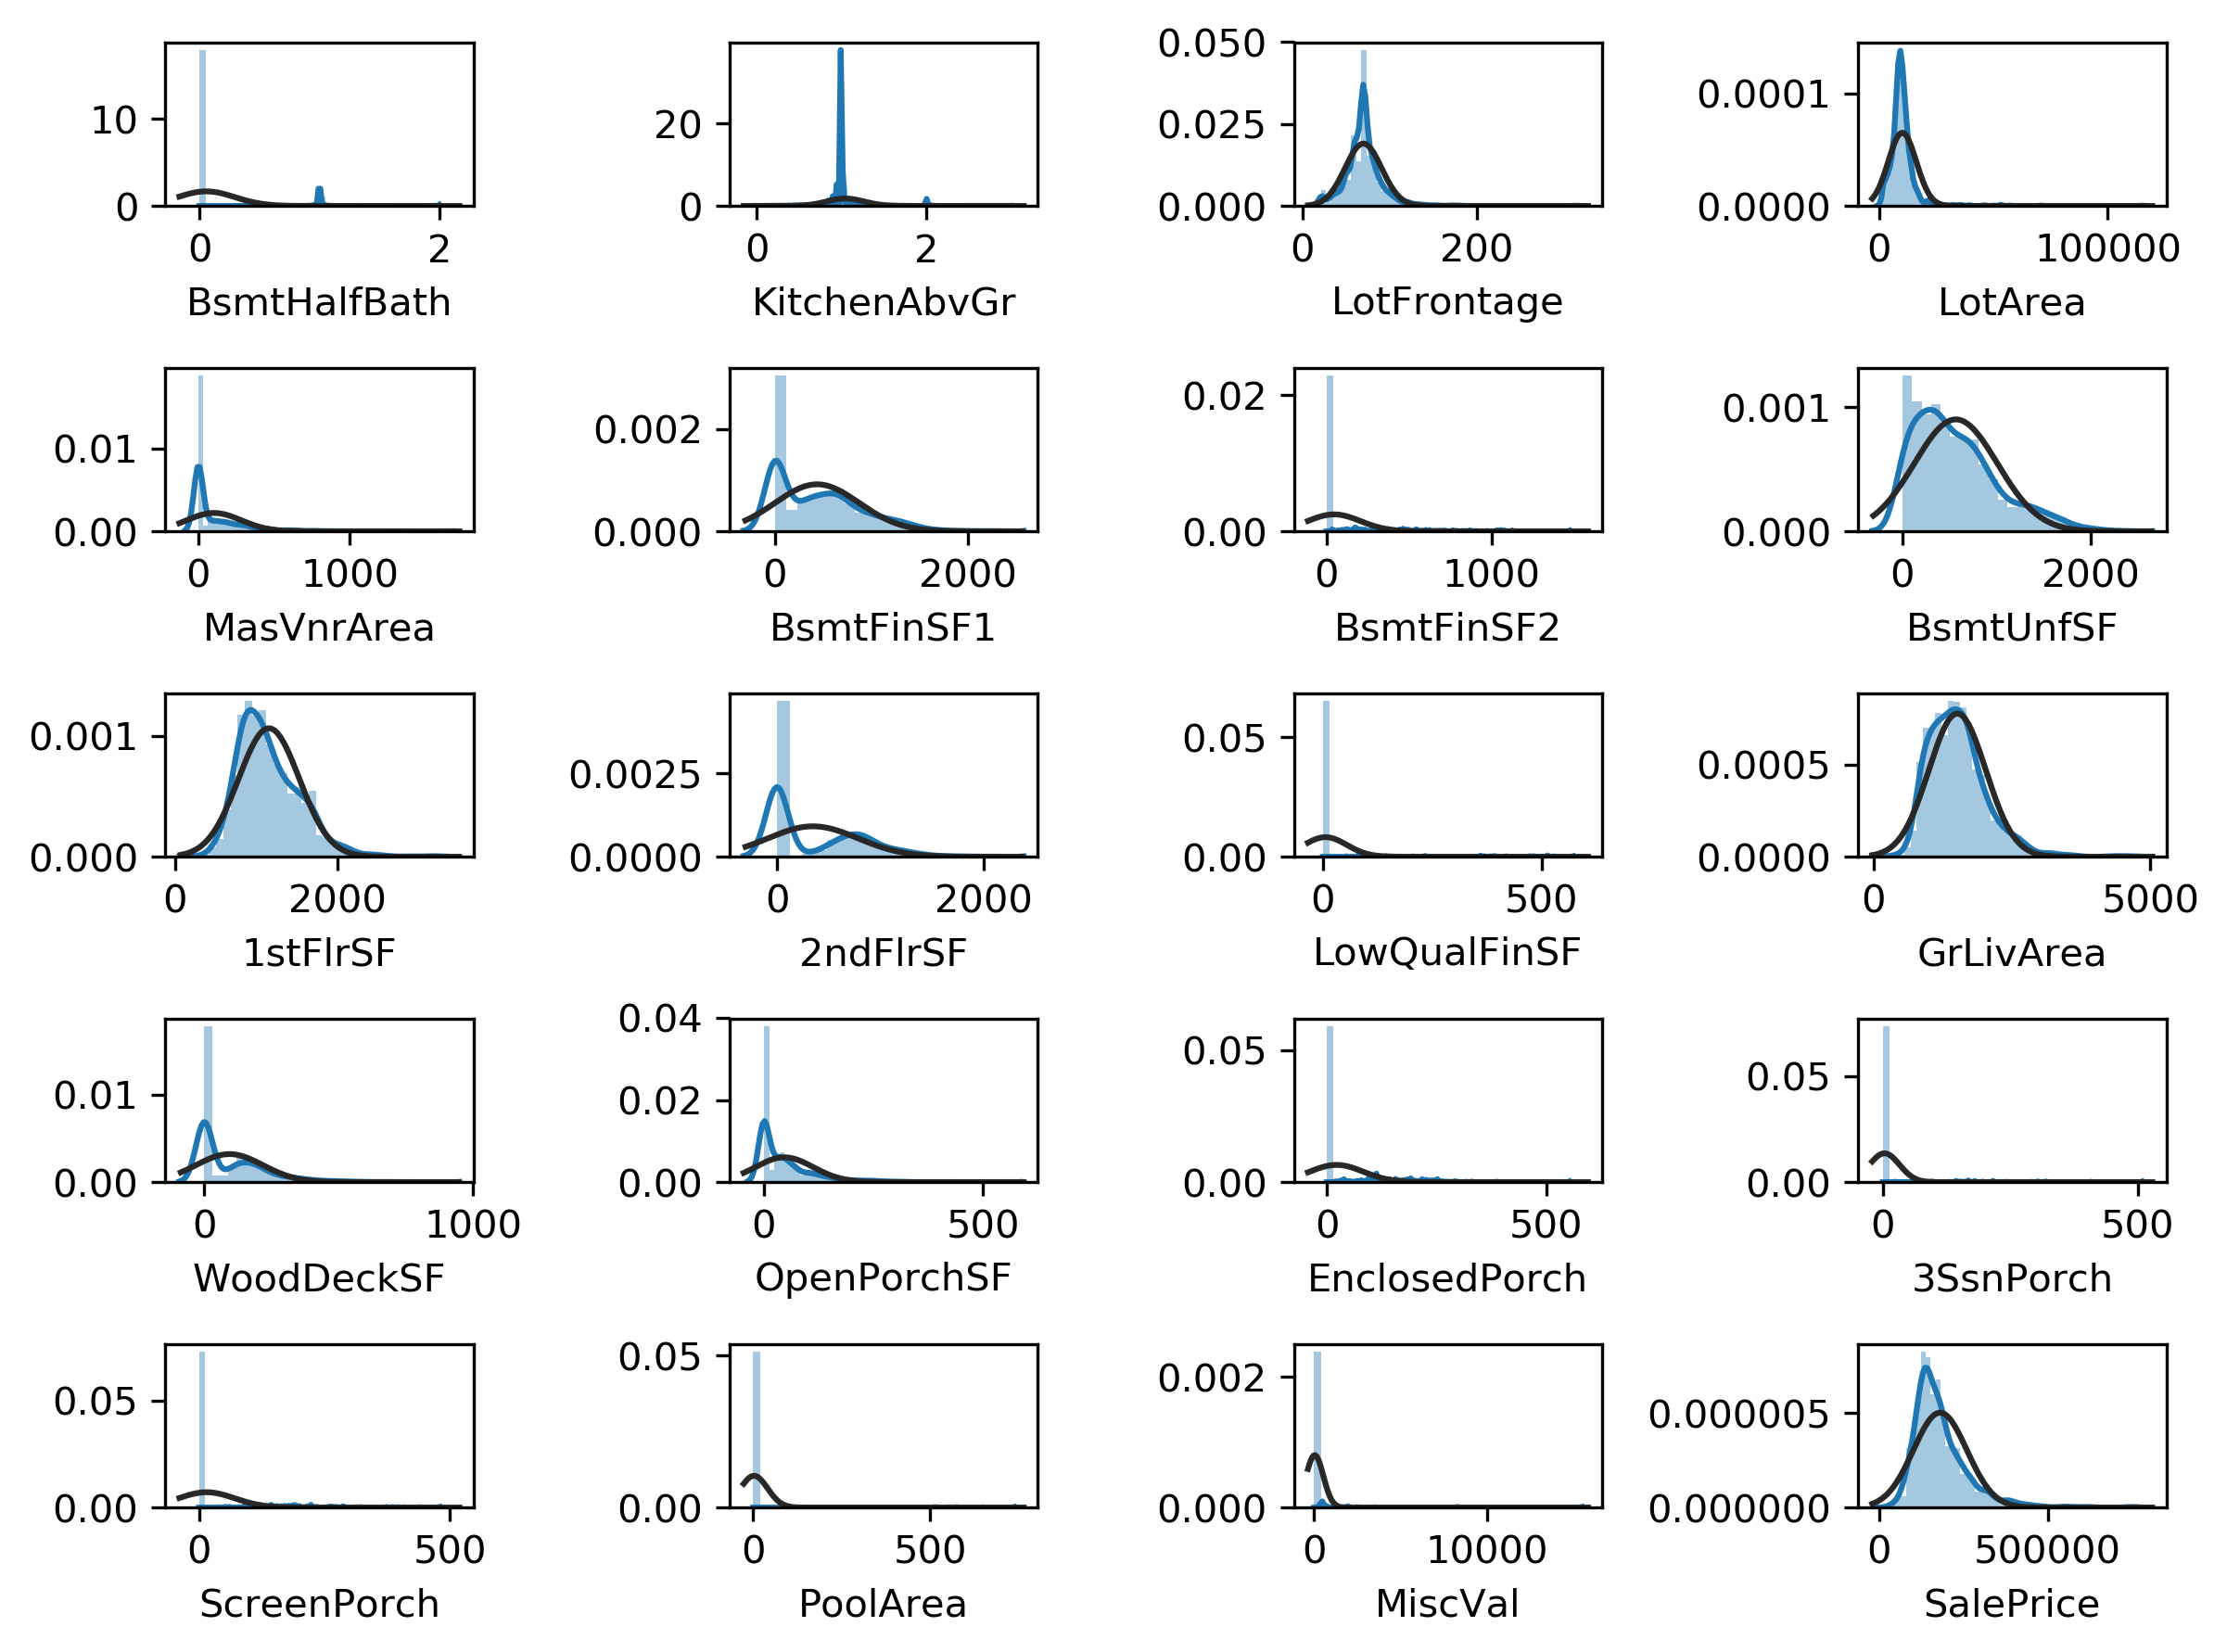

In [37]:
def distplot(df, cols, ncols):
    nrows = ceil(len(cols) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 6), dpi=300)
    for idx in range(0, len(cols)):
        x = (int) (idx / ncols)
        y = (int) (idx % ncols)
        attr = cols[idx]
        sns.distplot(df[attr], fit=norm, ax=axes.item((x, y)))
    plt.tight_layout()

numeric = discrete + continuous
df_skew = df_train[numeric].apply(lambda x: stats.skew(x.astype('float')))
df_skew = df_skew[abs(df_skew) > 0.75]

# before transformation
distplot(df_train, df_skew.index, 4)

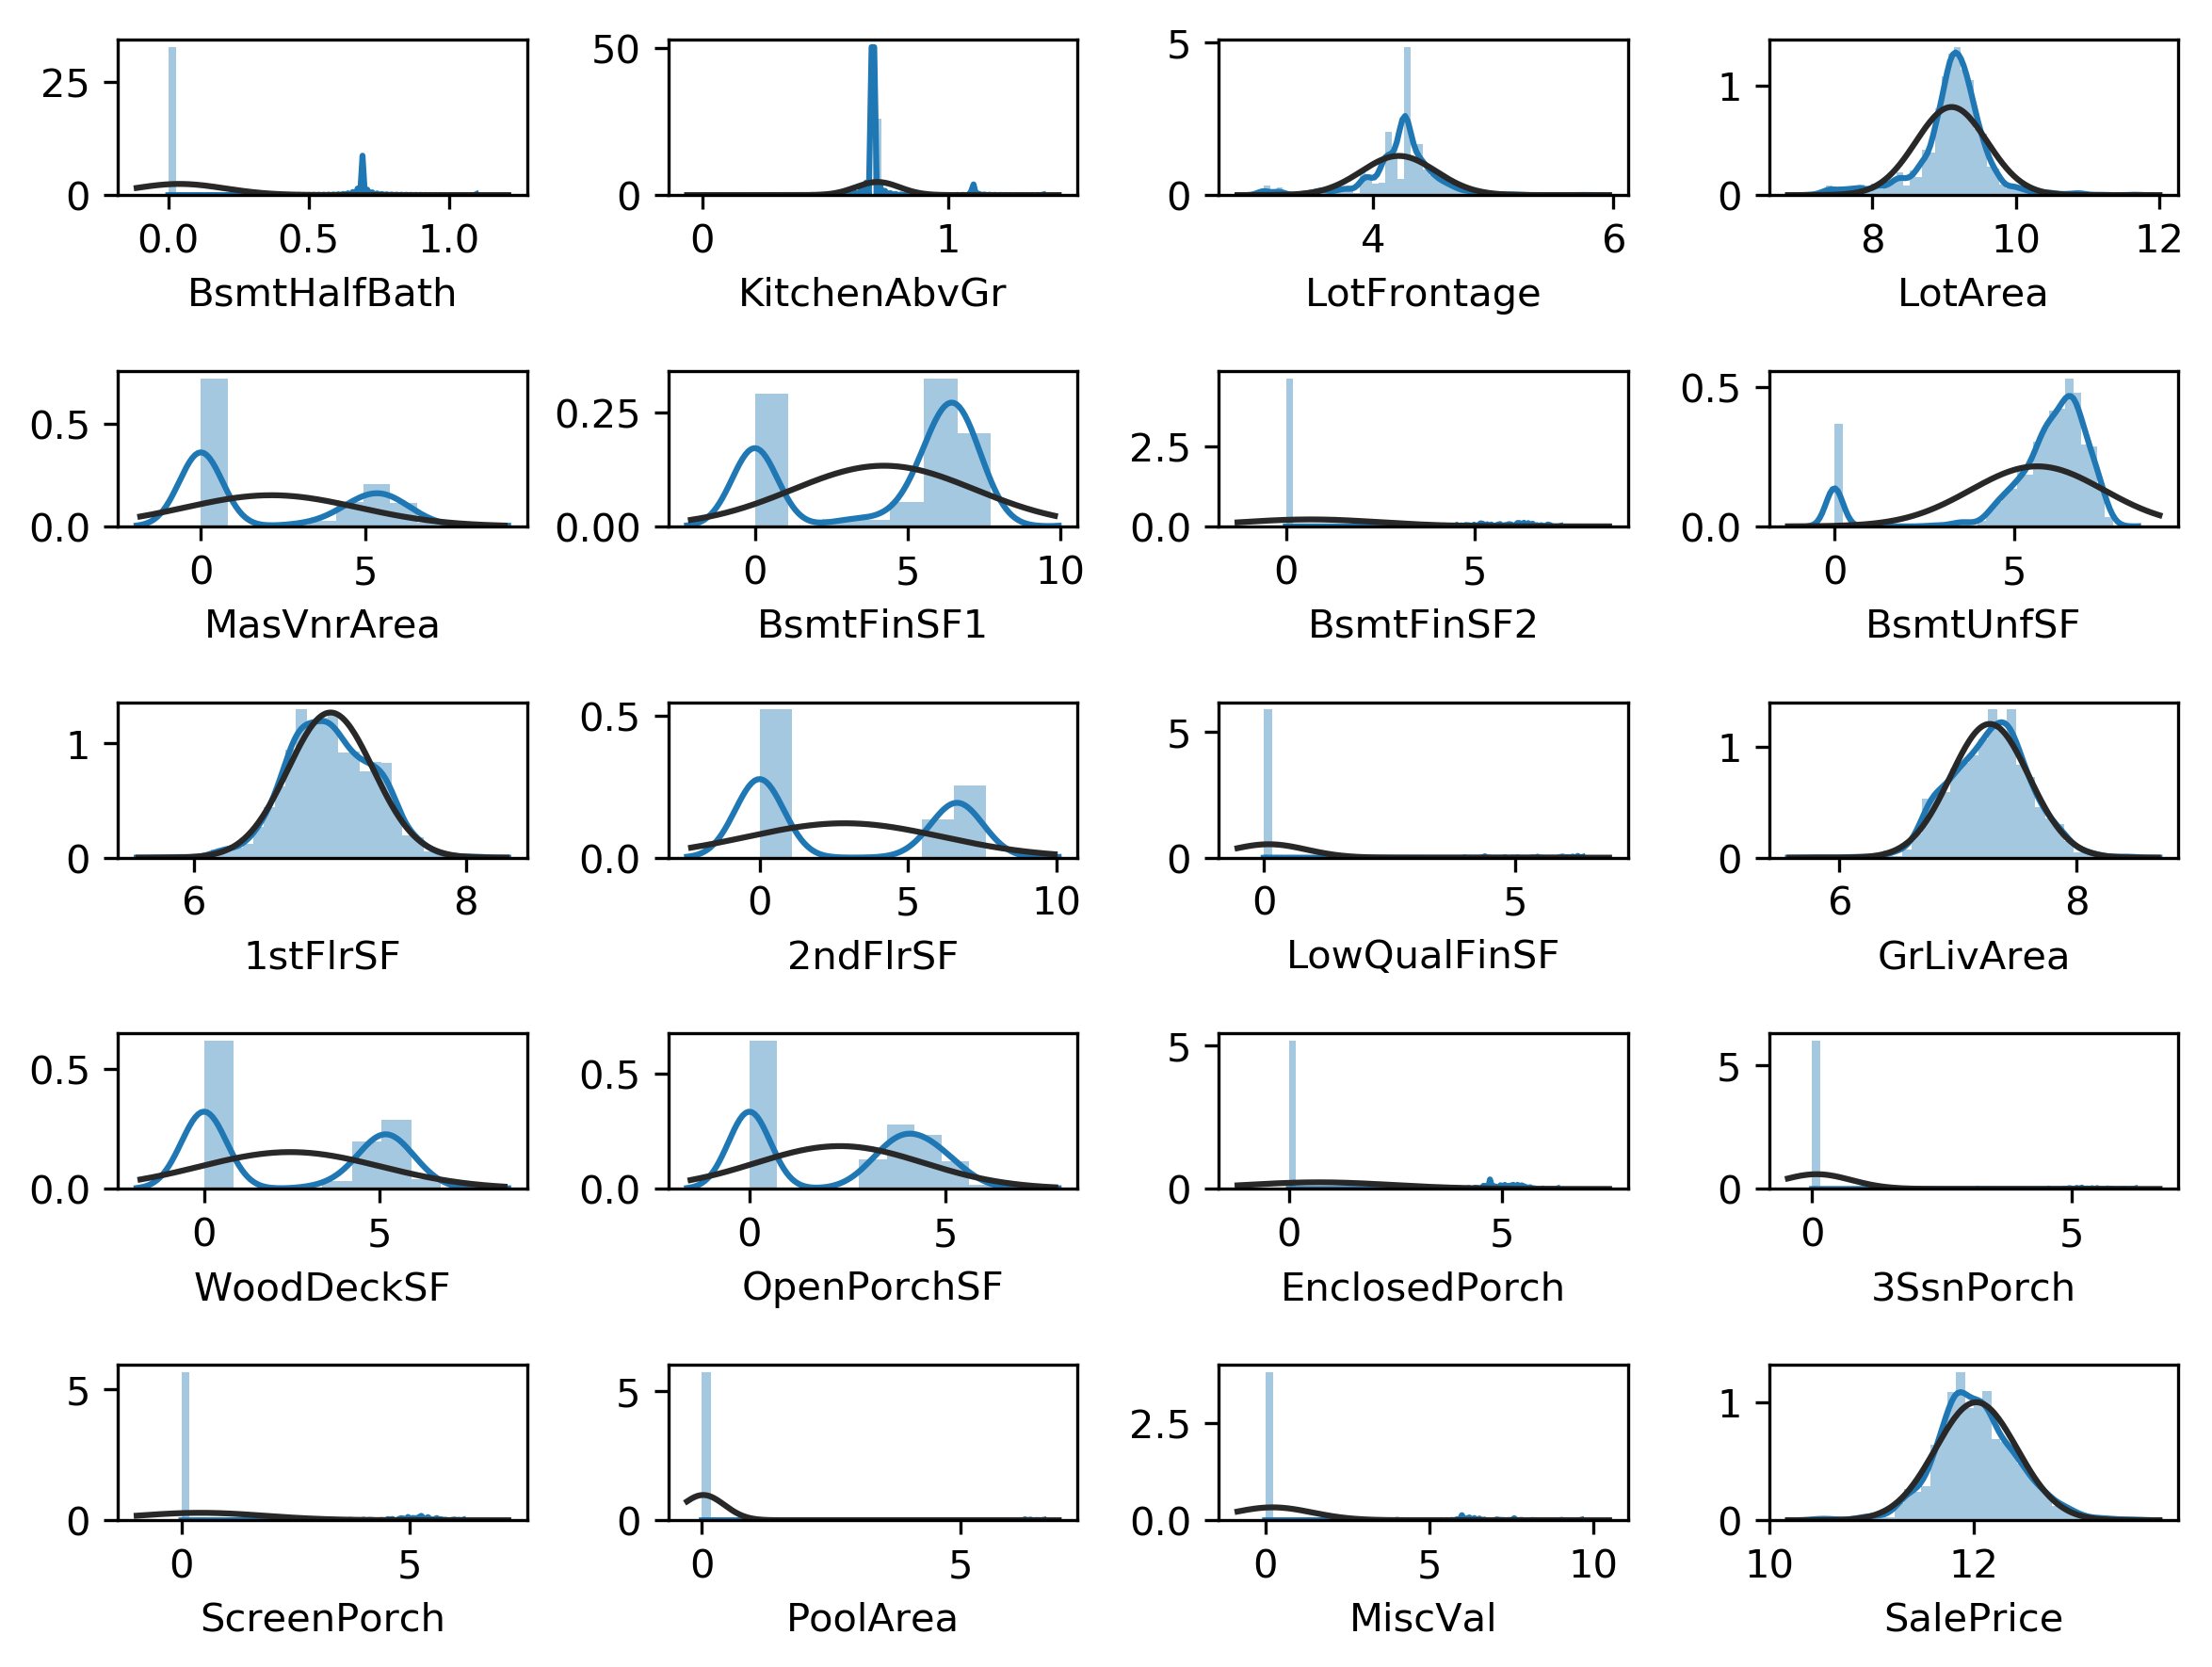

In [38]:
for col in df_skew.index:
    df_train[col] = np.log1p(df_train[col])
    df_test[col] = np.log1p(df_test[col])

# after transformation
distplot(df_train, df_skew.index, 4)

利用盒鬚圖，探討類別與非類別變數與房價之變化特徵

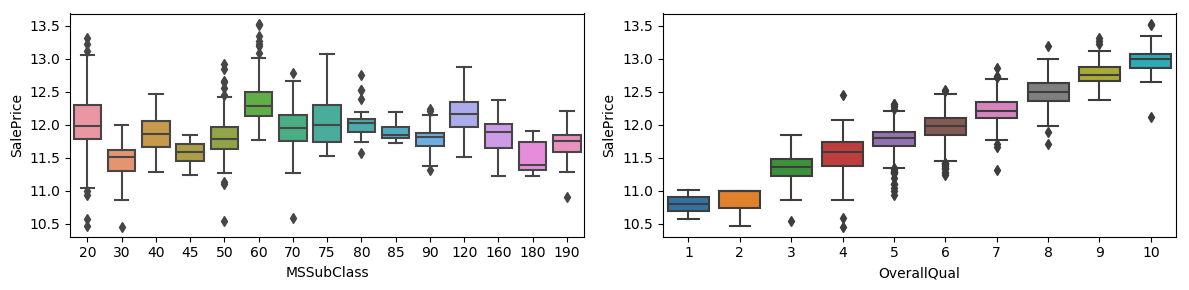

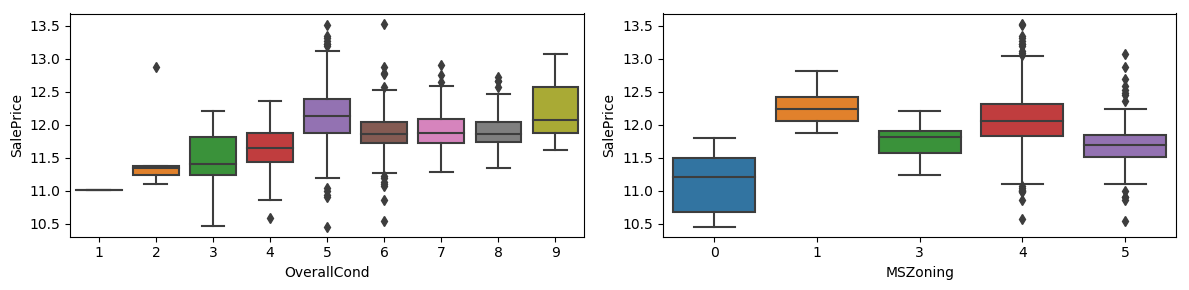

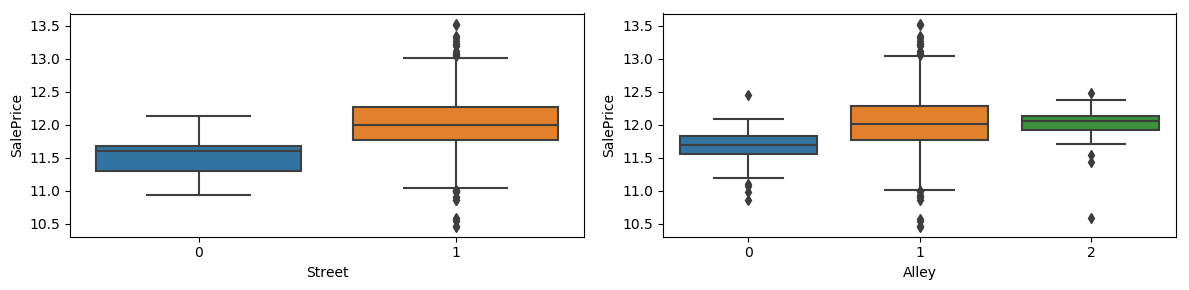

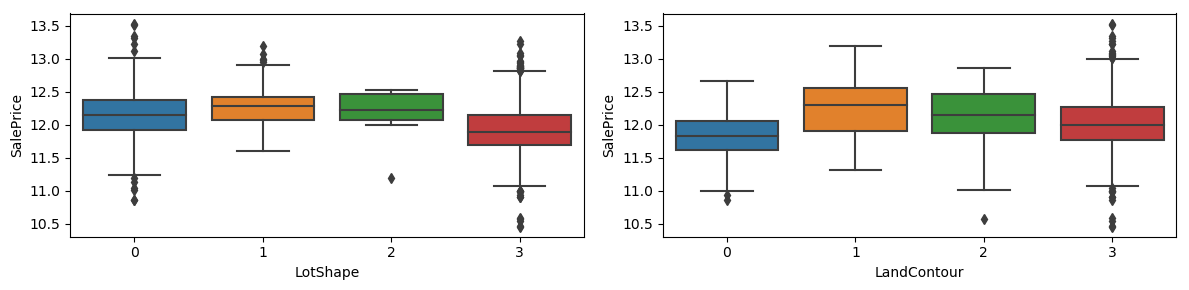

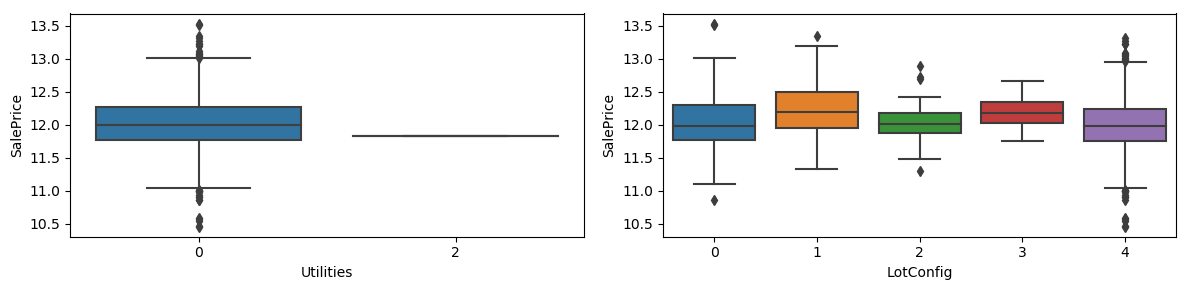

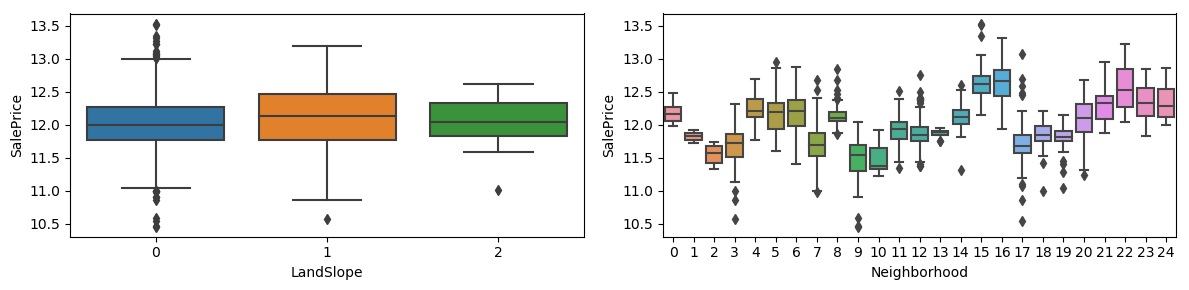

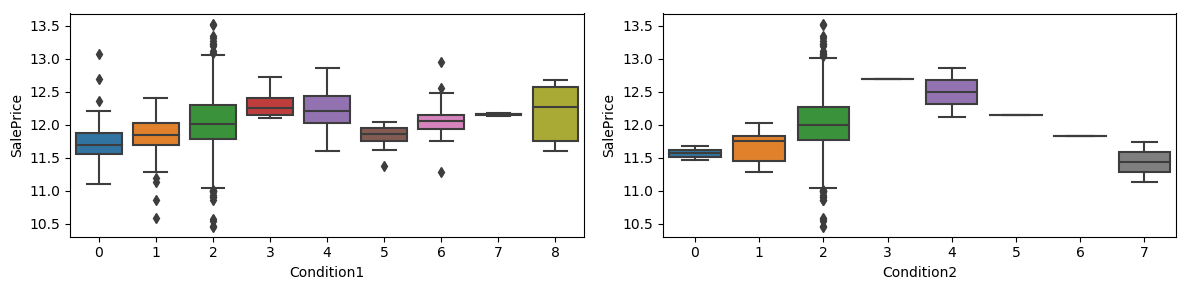

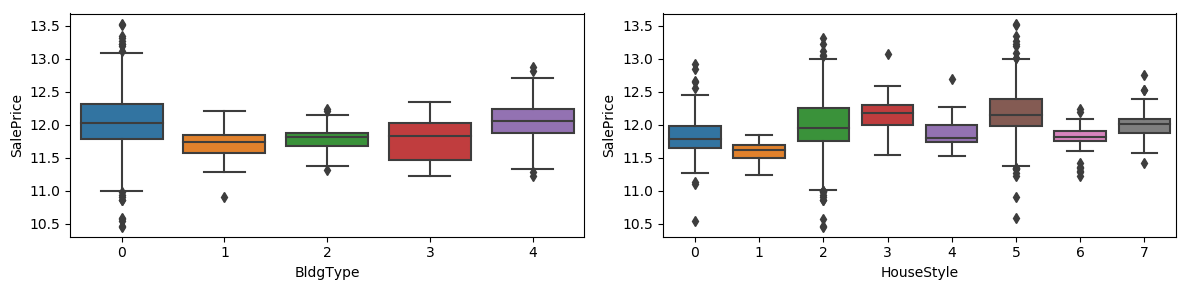

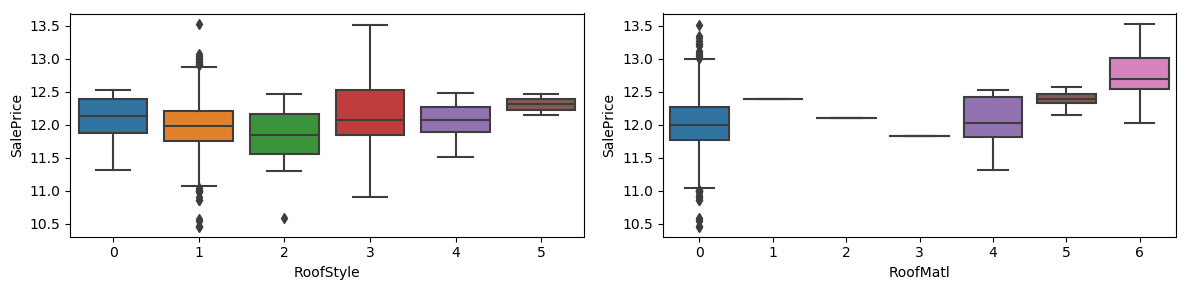

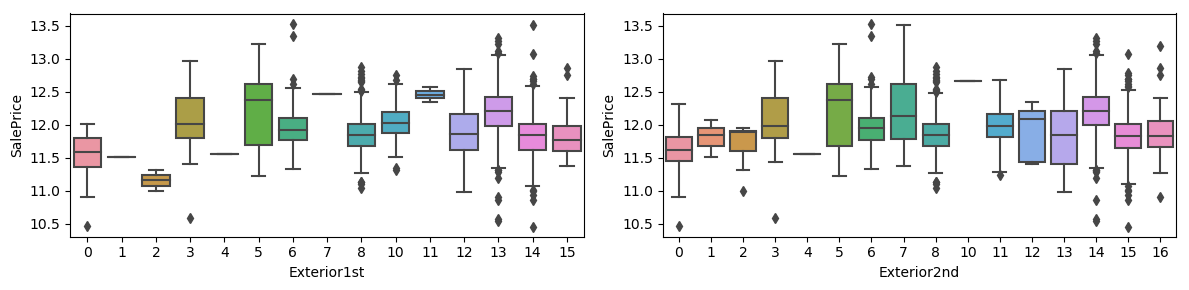

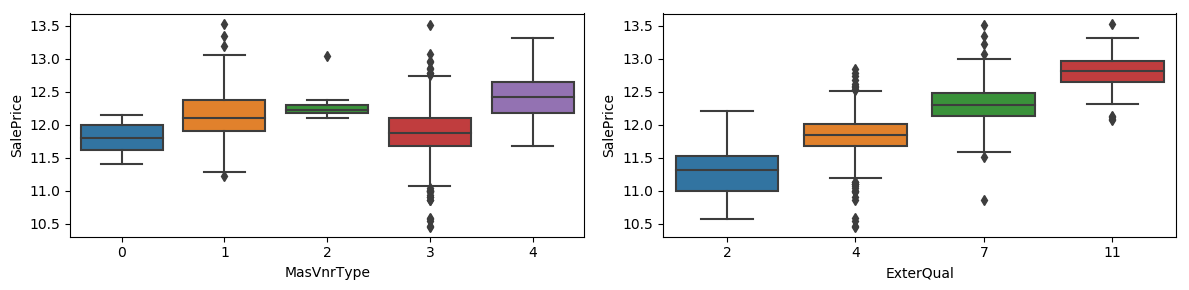

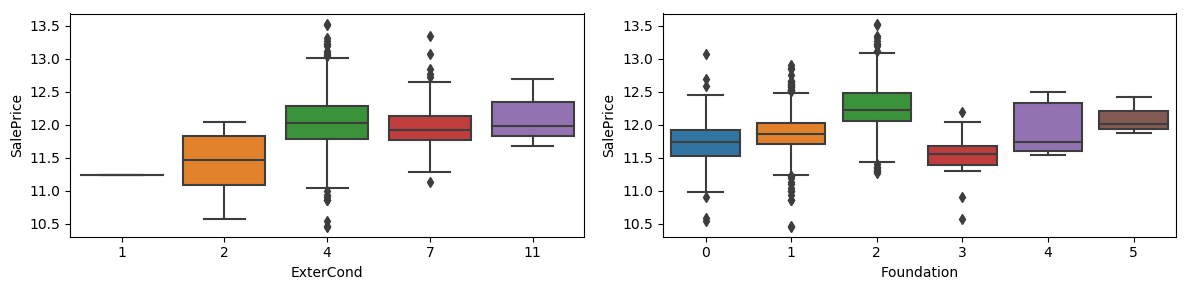

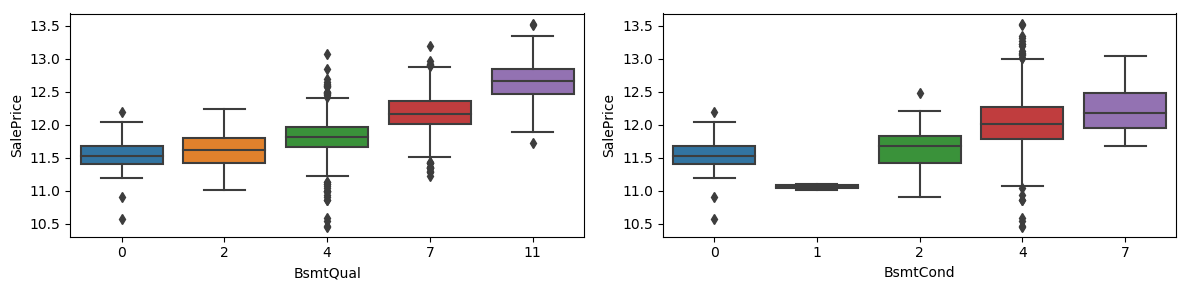

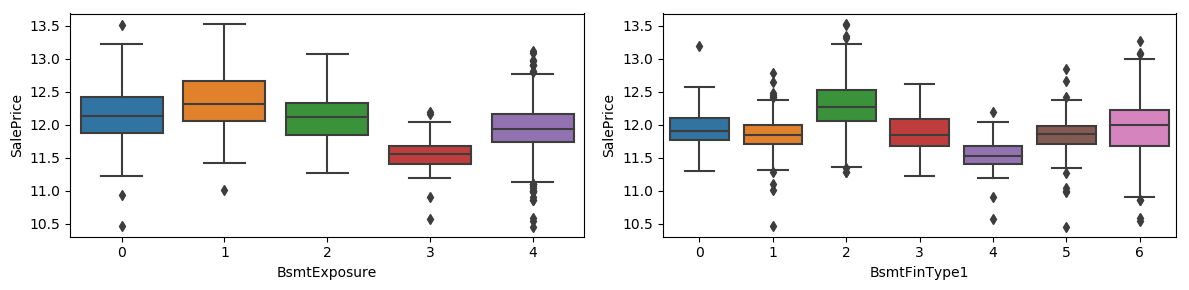

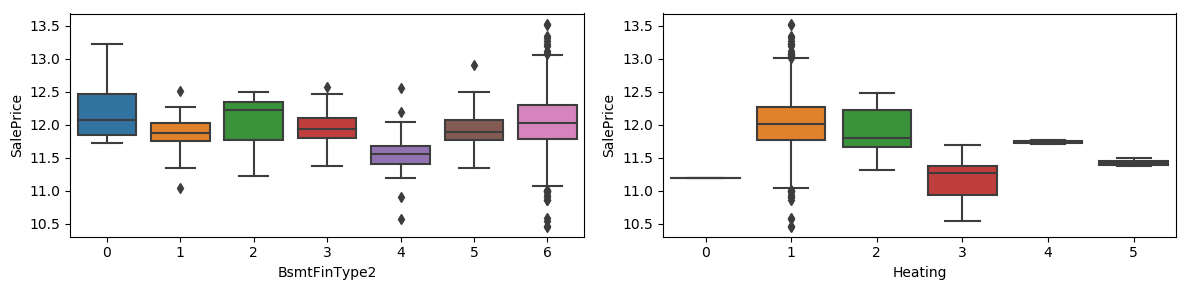

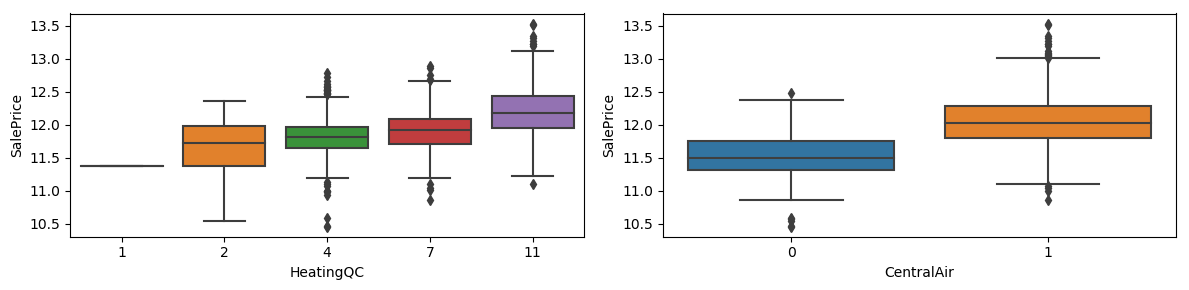

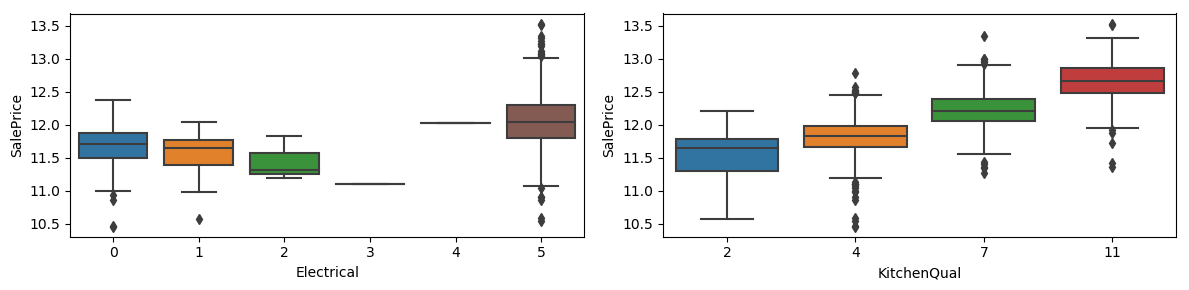

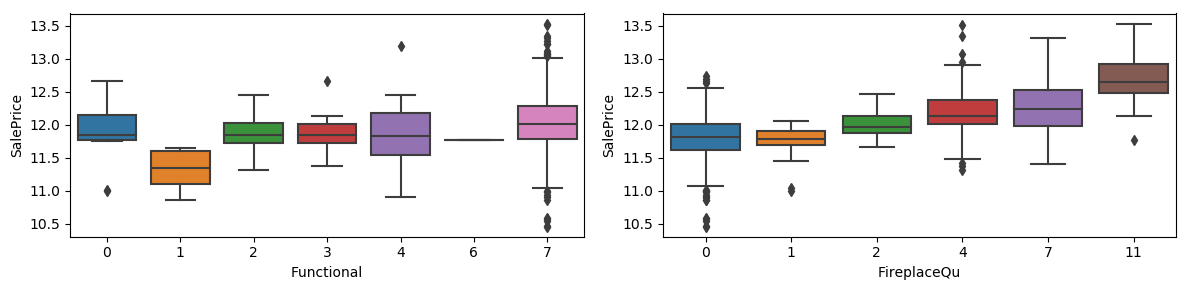

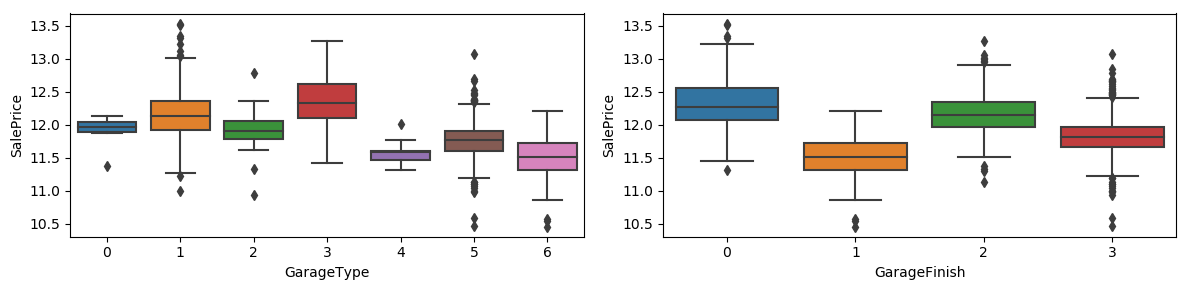

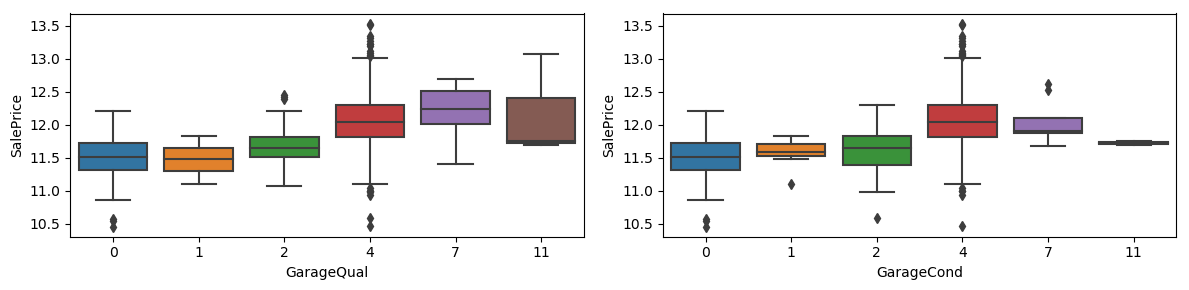

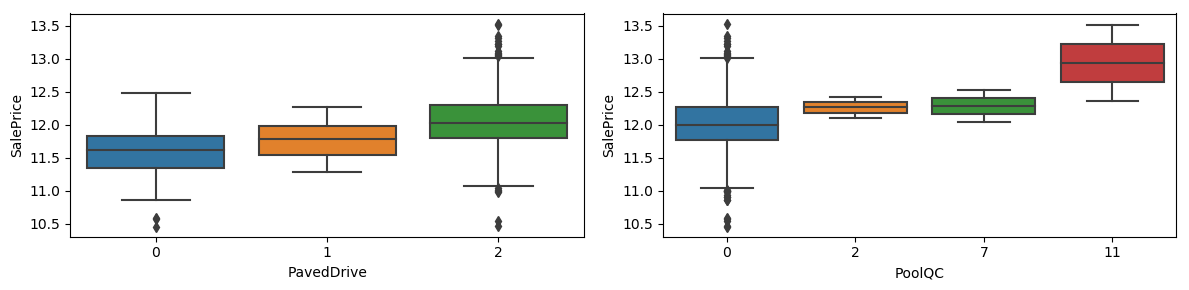

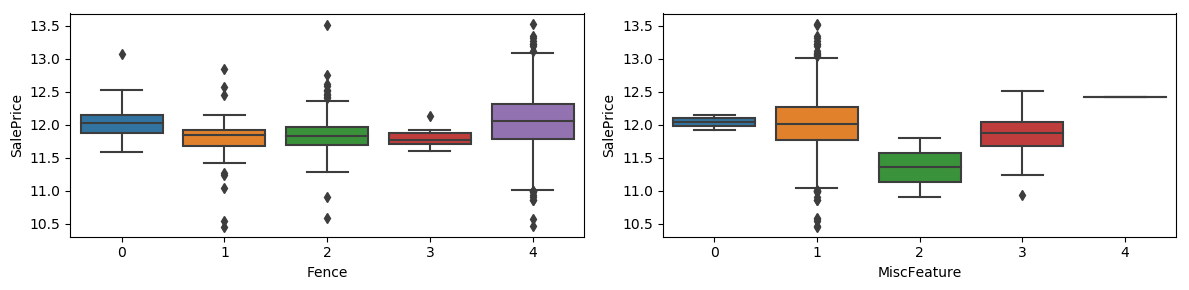

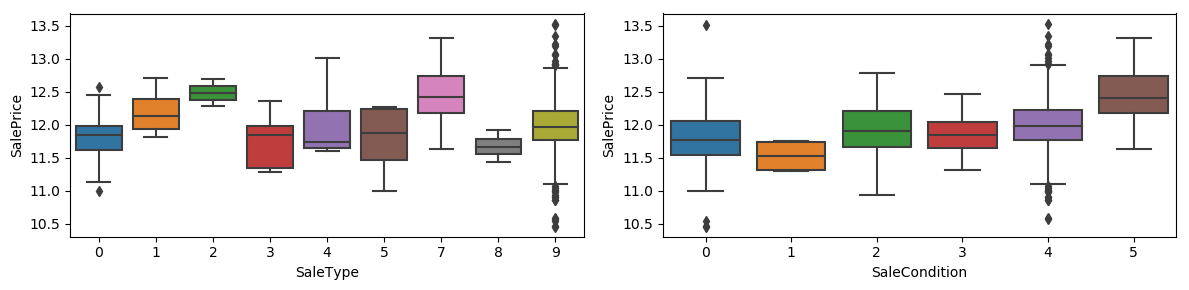

In [39]:
def boxplot(df, cols, ncols):
    for lst in chunks(cols, ncols):
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 3), dpi=100)
        for idx in range(0, len(lst)):
            attr = lst[idx]
            data = pd.concat([df['SalePrice'], df[attr]], axis=1)
            sns.boxplot(x=attr, y='SalePrice', data=data, ax=axes[idx])
        plt.tight_layout()

boxplot(df_train, icategorical + categorical, 2)

In [40]:
drops = ["BsmtHalfBath", "KitchenAbvGr", "MasVnrArea", "BsmtFinSF1", 
         "BsmtFinSF2", "2ndFlrSF", "LowQualFinSF", "WoodDeckSF", 
         "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", 
         "PoolArea", "MiscVal", "Utilities", "Condition2", "RoofMatl"]
df_train = df_train.drop(drops, axis=1)
df_test = df_test.drop(drops, axis=1)
df_test = df_test.drop('SalePrice', axis=1)

探討各變數間的相關係數 整體品質與房價為高相關

In [41]:
corr = df_train.corr()
cols = df_train.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        attr1 = cols[i];
        attr2 = cols[j];
        if corr[attr1][attr2] > 0.7:
            print("(%s, %s): %.2f" % (attr1, attr2, corr[attr1][attr2]))

(1stFlrSF, TotalBsmtSF): 0.78
(BldgType, MSSubClass): 0.75
(ExterQual, KitchenQual): 0.72
(ExterQual, OverallQual): 0.72
(Exterior1st, Exterior2nd): 0.86
(FireplaceQu, Fireplaces): 0.80
(GarageArea, GarageCars): 0.89
(GarageCond, GarageQual): 0.90
(GarageYrBlt, YearBuilt): 0.78
(GrLivArea, SalePrice): 0.73
(GrLivArea, TotRmsAbvGrd): 0.82
(OverallQual, SalePrice): 0.82


In [42]:
drops = ["BldgType", "ExterQual", "GarageYrBlt", "Exterior2nd", "KitchenQual", 
         "1stFlrSF", "TotRmsAbvGrd", "FireplaceQu", "GarageCars", "GarageCond"]
df_train = df_train.drop(drops, axis=1)
df_test = df_test.drop(drops, axis=1)

觀察資料維度

In [43]:
df_train.shape

(1456, 53)

In [44]:
df_test.shape

(1459, 52)

利用均方根误差(RMSE)作為模式適宜性評估，並且將預測資料進行匯出

再資料切割為90%訓練與10%測試

In [45]:
# evaluate with k-fold cross validation, and report RMSE score
def evaluate(model, X, y, k=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=2)
    y_pr = np.zeros((X.shape[0],))
    for train_index, test_index in kf.split(X):
        X_tr, X_te = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_te = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_tr, y_tr)
        y_pr[test_index] = model.predict(X_te)
    err = sqrt(mean_squared_error(y_pr, y))
    print("RMSE: %.5f" % err)
def coef(model, X):
    for l, r in sorted(zip(X.columns, model.coef_), key=lambda x: abs(x[1]), reverse=True)[:5]:
        print("(%s, %.5f)" % (l, r))
def print_params(est, X, y, n=100):
    print("Chosen parameter on %d datapoints: %s" % 
          (n,est.fit(X[:n], y[:n]).best_params_))
def generate_submission(model, X):
    suffix = model.__class__.__name__.lower()
    y_pr = model.predict(X)
    result = np.exp(y_pr)
    submission = pd.DataFrame({'Id': X.index.values, 'SalePrice': result})
    submission.to_csv("submission_" + suffix + ".csv", index=None)

In [47]:
X_train = df_train.drop("SalePrice", axis=1)
y_train = df_train["SalePrice"]
X_test = df_test
# settings
nJobs = psutil.cpu_count()
kFold = 10

載入GradientBoostingRegression tree 模型 (y 為房價，X為所有變數)

n_estimators: 疊代次數 max_depth:最大深度，由於特徵值過多，會導致演算法無限的延伸的分支下去，所以需設立最大分支數 min_samples_leaf: 葉子節點最少樣本數 max_features: 畫分数據集時考慮最多的特徵值数量 資料來源: https://www.cnblogs.com/pinard/p/6160412.html

In [51]:
from sklearn.ensemble import GradientBoostingRegressor
max_features = [0.05, 0.15, 0.30, 0.60, 0.80, "sqrt", "log2", None]
params = {
    'n_estimators': 3000,
    'learning_rate': 0.05,
    'max_depth': 3,
    'min_samples_leaf': 15,
    'min_samples_split': 10,
    'loss': 'huber'
}
gbdt = GradientBoostingRegressor(**params)
est = GridSearchCV(gbdt, param_grid={"max_features": max_features})
print_params(est, X_train, y_train, 400)

Chosen parameter on 400 datapoints: {'max_features': 0.15}


建立房價之GradientBoostingRegression tree 模型，其RMSE為0.12361，代表均方根誤差為0.12361 ，意旨觀測值與真值偏差的平方和觀測次数n比值的平方根，其值越小代表模型為精確

In [52]:
params = {
    'n_estimators': 3000,
    'learning_rate': 0.05,
    'max_depth': 3,
    'min_samples_leaf': 15,
    'min_samples_split': 10,
    'loss': 'huber',
    'max_features': 'log2'
}
gbdt = GradientBoostingRegressor(**params)
# cross validation
evaluate(gbdt, X_train, y_train, kFold)

RMSE: 0.12435


將預測資料匯出

In [53]:
# generate submission
generate_submission(gbdt, X_test)

In [55]:
print("Kaggle score: 0.12755")
print("Kaggle ranking: 1384")

Kaggle score: 0.12755
Kaggle ranking: 1384


![Image of Yaktocat](./Kaggle_score2.PNG)

預測成果並沒有百分之百預測準確，原因可能在於類別變數與數值變數間之運算不夠明確，未來可以參考模糊理論結合深度學習進行預測